In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Reshape, Input, Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(r"C:\Users\himan\Desktop\7th GAN\updataDataSets.csv", 
                 index_col='From Date', 
                 parse_dates=['From Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 33067 entries, 2019-02-18 00:00:00 to 2022-12-31 00:00:00
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SL NO        33067 non-null  int64  
 1   PM2.5        31251 non-null  float64
 2   PM10         31790 non-null  float64
 3   NO           31396 non-null  float64
 4   NO2          32393 non-null  float64
 5   Nox          32616 non-null  float64
 6   NH3          31705 non-null  float64
 7   SO2          32592 non-null  float64
 8   CO           32616 non-null  float64
 9   Ozone        32473 non-null  float64
 10  Benzene      30961 non-null  float64
 11  Eth-Benzene  16450 non-null  float64
 12  MP-Xylene    22659 non-null  float64
 13  WS           31483 non-null  float64
 14  WD           31528 non-null  float64
 15  SR           20184 non-null  float64
 16  BP           21876 non-null  float64
 17  AT           31462 non-null  float64
 18  RF         

C:\Users\himan\AppData\Local\Temp\ipykernel_23148\4218735721.py:1: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(r"C:\Users\himan\Desktop\7th GAN\updataDataSets.csv",


In [3]:
print("Original Dataset:")
print(df.head())

Original Dataset:
                     SL NO  PM2.5   PM10    NO   NO2    Nox    NH3    SO2  \
From Date                                                                   
2019-02-18 00:00:00      1  58.04  81.06  1.81  6.40   9.66  27.18  13.77   
2019-02-18 01:00:00      2  60.00  82.39  1.91  6.08   9.70  26.46  13.64   
2019-02-18 02:00:00      3  55.50  73.42  2.22  6.71  10.86  27.06  13.64   
2019-02-18 03:00:00      4  66.56  96.04  2.79  7.00  12.10  26.34  13.72   
2019-02-18 04:00:00      5  67.08  97.21  3.29  9.45  15.53  25.16  13.80   

                       CO  Ozone  Benzene  Eth-Benzene  MP-Xylene    WS  \
From Date                                                                 
2019-02-18 00:00:00  0.49  15.73     0.92          NaN       0.33  1.86   
2019-02-18 01:00:00  0.44  18.36     0.84          NaN       0.29  1.54   
2019-02-18 02:00:00  0.44  34.54     0.77          NaN       0.23  0.66   
2019-02-18 03:00:00  0.45  31.85     0.82          NaN       0.21  

In [4]:
df = df.drop(columns=['SL NO'])
# Handling missing values
df = df.fillna(0) 

In [5]:
# Extract features
features = df[['PM2.5', 'PM10', 'NO', 'NO2', 'Nox', 'NH3', 'SO2', 'CO', 'Ozone', 'Benzene',
               'Eth-Benzene', 'MP-Xylene', 'WS', 'WD', 'SR', 'BP', 'AT', 'RF']].values

In [6]:
# Normalize data (replace 'None' with appropriate scaling method)
normalized_features = (features - features.min(axis=0)) / (features.max(axis=0) - features.min(axis=0))

In [7]:
# Define generator model
def build_generator(latent_dim, n_features):
    model = Sequential()
    model.add(Dense(100, input_dim=latent_dim, activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(n_features, activation='sigmoid'))
    model.add(Reshape((1, n_features)))
    return model

In [8]:
# Define discriminator model
def build_discriminator(input_shape):
    model = Sequential()
    model.add(LSTM(100, input_shape=input_shape, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [9]:
# Define GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [10]:
# Hyperparameters
latent_dim = 100
n_features = normalized_features.shape[1]
input_shape = (1, n_features)

In [11]:
# Build and compile models
generator = build_generator(latent_dim, n_features)
discriminator = build_discriminator(input_shape)

discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [12]:
# Training loop
epochs = 2000
batch_size = 32

for epoch in range(epochs):
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    generated_data = generator.predict(noise)

    real_data = normalized_features[np.random.randint(0, normalized_features.shape[0], batch_size)]
    real_data = np.reshape(real_data, (batch_size, 1, n_features))
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    # Train discriminator
    d_loss_real = discriminator.train_on_batch(real_data, real_labels)
    d_loss_fake = discriminator.train_on_batch(generated_data, fake_labels)

    # Check if train_on_batch returns valid logs
    if d_loss_real is not None and d_loss_fake is not None:
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        print(f"Epoch {epoch}, D Loss: {d_loss[0]}")

    # Train generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    valid_labels = np.ones((batch_size, 1))

    # Train GAN
    g_loss = gan.train_on_batch(noise, valid_labels)

    # Check if train_on_batch returns valid logs
    if g_loss is not None:
        print(f"Epoch {epoch}, G Loss: {g_loss}")

1/1 [==============================] - 0s 260ms/step


Epoch 0, D Loss: 0.6992626190185547
Epoch 0, G Loss: 0.6818583011627197
1/1 [==============================] - 0s 28ms/step
Epoch 1, D Loss: 0.6938223242759705
Epoch 1, G Loss: 0.6896712779998779
1/1 [==============================] - 0s 25ms/step
Epoch 2, D Loss: 0.6893103718757629
Epoch 2, G Loss: 0.6972293853759766
1/1 [==============================] - 0s 23ms/step
Epoch 3, D Loss: 0.6845551133155823
Epoch 3, G Loss: 0.705299437046051
1/1 [==============================] - 0s 22ms/step
Epoch 4, D Loss: 0.6805790960788727
Epoch 4, G Loss: 0.7122257351875305
1/1 [==============================] - 0s 21ms/step
Epoch 5, D Loss: 0.6771882772445679
Epoch 5, G Loss: 0.7203999757766724
1/1 [==============================] - 0s 22ms/step
Epoch 6, D Loss: 0.6741006672382355
Epoch 6, G Loss: 0.7275704145431519
1/1 [==============================] - 0s 24ms/step
Epoch 7, D Loss: 0.6710631251335144
Epoch 7, G Loss: 0.7331892848014832
1/1 [=

In [13]:
# Generate synthetic data
num_samples = 1000
noise = np.random.normal(0, 1, (num_samples, latent_dim))
generated_data = generator.predict(noise)

32/32 [==============================] - 0s 2ms/step


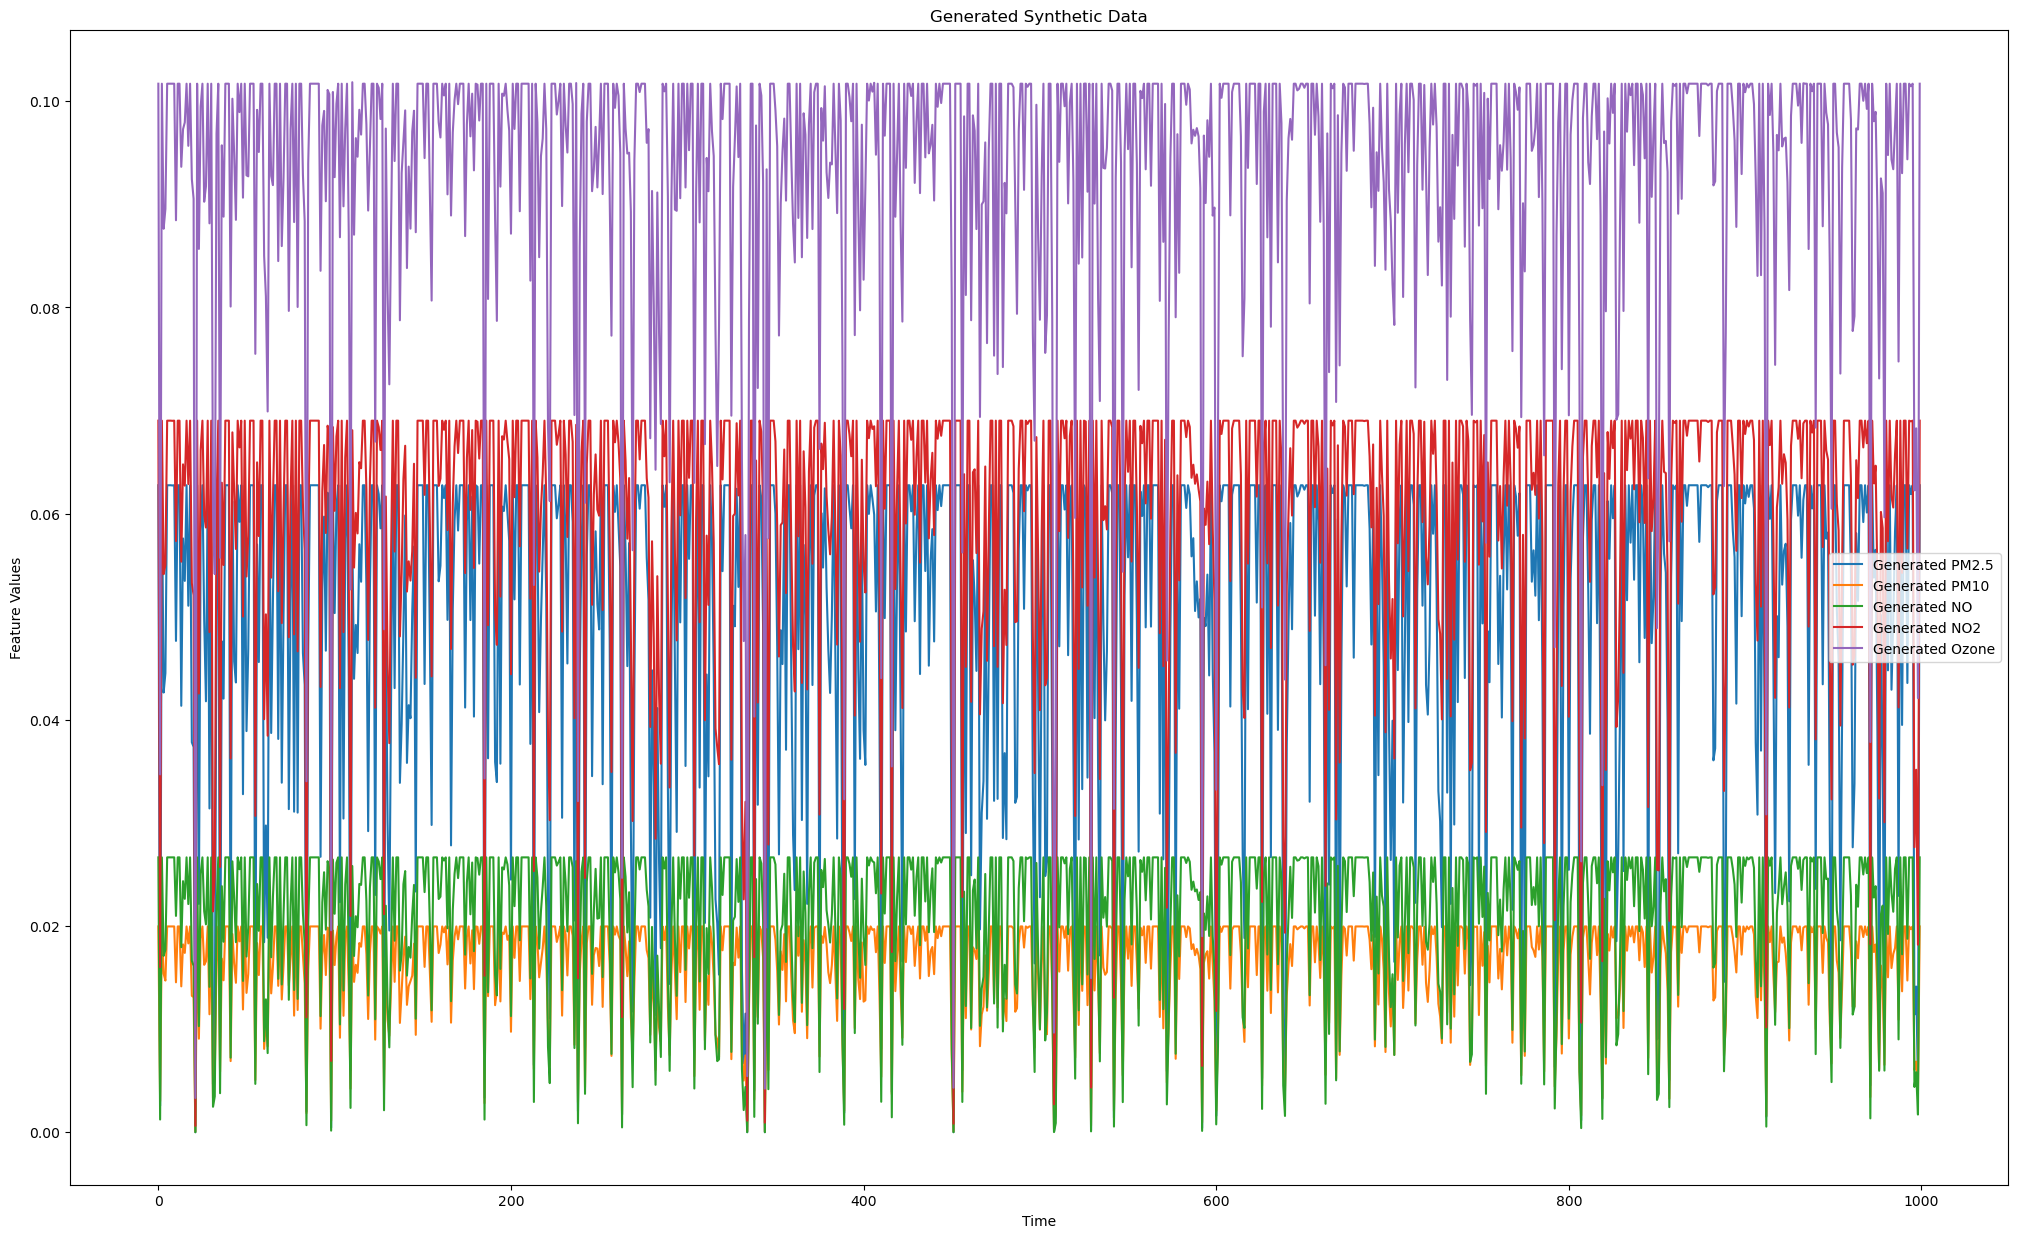

In [14]:
# Plotting
plt.figure(figsize=(25, 15))

# Choose a few features to plot (you can modify this based on your preferences)
features_to_plot = ['PM2.5', 'PM10', 'NO', 'NO2', 'Ozone']

for feature in features_to_plot:
    plt.plot(generated_data[:, 0, df.columns.get_loc(feature)], label=f'Generated {feature}')

plt.title('Generated Synthetic Data')
plt.xlabel('Time')
plt.ylabel('Feature Values')
plt.legend()
plt.show()

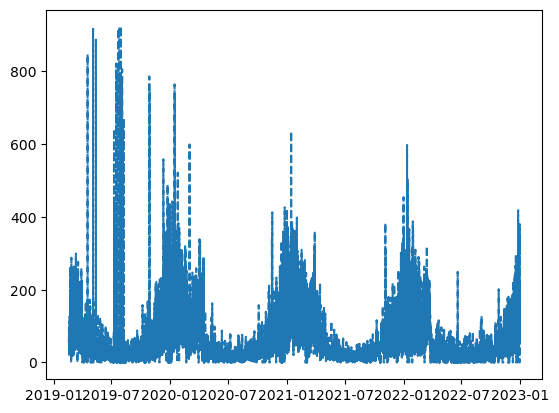

In [15]:
 plt.plot(df.index, df['PM2.5'].values, label='Real PM2.5', linestyle='--')

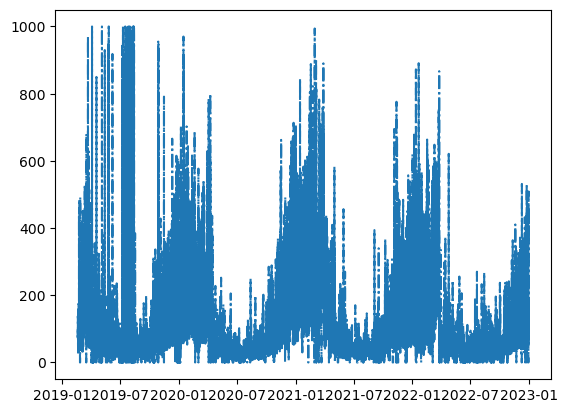

In [16]:
 plt.plot(df.index, df['PM10'].values, label='Real PM10', linestyle='-.')